In [1]:
# V2 Updates
# clean up custom function definitions
# make model loadable from other file

In [2]:
## LIBRARIES
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model, Sequential
from keras.layers import Conv1D,MaxPooling1D,LSTM,BatchNormalization,Dropout,Input,Dense,Bidirectional,Activation,Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.backend import squeeze
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from scipy import stats


/Users/alezel/anaconda2/envs/tensorflow36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# define custom metrics
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true-K.mean(y_true)))
    return (1-SS_res/(SS_tot+K.epsilon()))

def correlation_coefficient(y_true, y_pred):
    pearson_r, update_op = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true, name='pearson_r')
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'pearson_r'  in i.name.split('/')]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        pearson_r = tf.identity(pearson_r)
        return pearson_r*abs(pearson_r)
    

In [4]:
# evaluations on test data 
def eval_on_test(X_test, Y_test, model, fname):
    loss = model.evaluate(X_test, Y_test)
    Y_pred = model.predict(X_test)
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(Y_test[:,0], Y_pred[:,0])
    x = Y_pred
    y = Y_test
    if fname:
        plt.plot(x, y, 'o', label='original data')
        plt.plot(x, intercept + slope*x, 'r', label='fitted line')
        plt.legend()
        plt.title('R2 = {}'.format(rvalue*abs(rvalue)))
        plt.xlabel('Y_pred')
        plt.ylabel('Y_true')
        plt.savefig(fname+'.pdf', bbox_inches='tight')
    return loss, rvalue*abs(rvalue)


In [5]:
import os
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

#setting default path if interactive mode (run this cell only ONCE if in interactive mode)
if is_interactive():
    os.chdir("../")
    

In [6]:
import configparser
import sys

model_name = "THIS_model" #set HERE the model will be used as POC
models_dir = "./models"
weights_dir = "./weights"
results_dir = "./results"
data_path = "./data/THIS_data.npz"
weight_path = os.path.join(weights_dir, model_name)
csv_logger_path = os.path.join(results_dir, model_name + "_val_results.csv")
test_results_path = os.path.join(results_dir, model_name + "_test_results.csv")

for filename in [weight_path, csv_logger_path, test_results_path]:
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    
args = (sys.argv)
config_name = ""
if not is_interactive():
    model_name = args[1]
    config_name = args[2]
    weight_path = args[3]
    csv_logger_path = args[4]
    test_results_path = args[4] + "_testset"

suffix = "{epoch:03d}-{val_loss:.3f}.hdf5"
weight_model_path = "{}.{}".format(weight_path, suffix)


#hyperparameters    
DROPOUT = 0   # dropout
ALPHA = 0.01 # learnrate
BETA = 0.01
EPOCHS = 2 # epochs
MBATCH = 100 # batch size
SHUFFLE = True
#loading from config 
if not is_interactive():
    config_file = args[2]
    config = configparser.ConfigParser()
    config.read(config_file)
    ALPHA = config.getfloat('main', 'alpha')
    DROPOUT = config.getfloat('main', 'dropout')
    EPOCHS = config.getint('main', 'epochs')
    MBATCH = config.getint('main', 'mbatch')
    BETA = config.getfloat('main', 'beta')
    SHUFFLE = config.getboolean('main', 'SHUFFLE')
    


#external functions on data
module2load = model_name
if is_interactive():
    module2load = model_name + "_input.py"    
    module2load = os.path.join(models_dir, module2load)

import importlib.util
spec = importlib.util.spec_from_file_location("module.name", module2load)
foo = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo)
load_data = foo.load_data
POC_model = foo.POC_model

In [7]:
Xh_train,Xh_test,Xv_train,Xv_test,Y_train,Y_test = load_data(data_path)

X_train = list()
X_train.append(Xh_train)
#X_train.append(Xv_train)

X_test = list()
X_test.append(Xh_test)
#X_test.append(Xv_test)


In [8]:
# should go to model definition
if is_interactive():
    def POC_model(input_shape_hot,DR):

        X_input1 = Input(shape = input_shape_hot)

        # L 1: CONV 
        X1 = Conv1D(filters=128, kernel_size=30, strides=1, activation='relu')(X_input1) # 620/1 + 1 = 621
        X1 = BatchNormalization()(X1)
        X1 = Dropout(DR)(X1)

        X1 = Flatten()(X1)

        X = Dense(64, activation='relu')(X1)
        X = BatchNormalization()(X)
        X = Dropout(DR)(X) 

        X = Dense(1)(X)

        model = Model(inputs = [X_input1], outputs = X)

        return model


In [9]:
input_shape = Xh_train.shape[1:3]
model = POC_model(input_shape,DROPOUT)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 650, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 621, 128)          15488     
_________________________________________________________________
batch_normalization_1 (Batch (None, 621, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 621, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 79488)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5087296   
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
__________

In [10]:
opt = Adam(lr=ALPHA, beta_1=0.9, beta_2=0.999, decay=BETA)
model.compile(loss='mse', optimizer=opt, metrics=[coeff_determination, correlation_coefficient, 'mse'])


In [11]:
# Set callbacks
# checkpoint
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/
# https://keras.io/callbacks/ - for now save every epoch

checkpoint = ModelCheckpoint(weight_model_path, monitor='val_loss', verbose=0, 
                             save_best_only=False, save_weights_only=False, mode='auto', period=1)

# tensorboard
# http://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/

tensorboard = TensorBoard(log_dir='./tensorboard_logs/' + model_name + "_" + config_name)

csv = CSVLogger(csv_logger_path, separator = ",", append = True)

callbacks_list = [checkpoint, tensorboard, csv]

# in terminal run: tensorboard --logdir=logs/
# val_loss error is in callbacks, probably modelcheckpoint

In [12]:
#checking if model exist then load best
import glob
import re

def find_best_model(all_models):
        epochs = []
        losses = []
        for i, file in enumerate(all_models):
            groups = re.findall(weight_path + '.(.*)-(.*).hdf5', file)
            if groups:
                epochs.append(int(groups[0][0]))
                losses.append(float(groups[0][1]))
        return (all_models[np.argmin(losses)] )
all_models = [os.path.join(os.path.dirname(weight_path), f) \
              for f in os.listdir(os.path.dirname(weight_path)) \
                  if re.match(os.path.basename(weight_path) + '\.(.*)-(.*).hdf5', f)]
#all_models = glob.glob(weight_path +'*.hdf5')

if all_models:
    best_model = find_best_model(all_models)
    print("Loading weights from {}".format(best_model))
    model.load_weights(best_model)



Loading weights from ./weights/THIS_model.002-0.696.hdf5


In [13]:
# keras model checkpoint KeyError: 'val_loss'
# fix: https://github.com/keras-team/keras/issues/6104
# must add validation_split=xx

model.fit(X_train, Y_train, batch_size=MBATCH, epochs=EPOCHS, validation_split=0.1, shuffle=SHUFFLE, callbacks=callbacks_list)

Train on 3605 samples, validate on 401 samples
Epoch 1/2
3605/3605 [==============================] - 9s 2ms/step - loss: 0.6977 - coeff_determination: 0.1245 - correlation_coefficient: nan - mean_squared_error: 0.6977 - val_loss: 0.7522 - val_coeff_determination: -1377.9791 - val_correlation_coefficient: 0.2169 - val_mean_squared_error: 0.7522
Epoch 2/2
3605/3605 [==============================] - 8s 2ms/step - loss: 0.3924 - coeff_determination: 0.5039 - correlation_coefficient: 0.2870 - mean_squared_error: 0.3924 - val_loss: 0.9022 - val_coeff_determination: -21381.6295 - val_correlation_coefficient: 0.3363 - val_mean_squared_error: 0.9022


446/446 [==============================] - 0s 934us/step


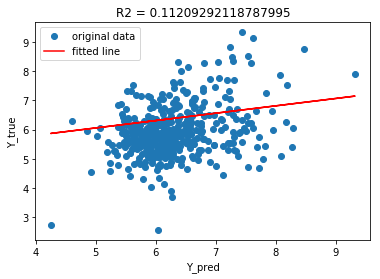

In [14]:
# tests data on test set
   
test_loss, test_r2 = eval_on_test(X_test, Y_test, model, test_results_path)


In [15]:
# Save test results
d = {'coeff_determination' : [test_loss[1]], 
     'correlation_coefficient' : [test_loss[2]],
     'loss' : [test_loss[3]],
     'mean_squared_error' : [test_loss[0]],
     'R2_scipy_stats' : [test_r2]}

test_df = pd.DataFrame(data=d)
test_df.to_csv(test_results_path, index=False)
